# Assignment 1

## Question 2

In [1]:
import numpy as np
import networkx as nx
import copy
from numpy import partition
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import graph_tool.all as gt
from collections import Counter

In [85]:
with open('ia-email-univ/ia-email-univ.mtx', 'r') as f:
    lines = f.readlines()
    edge_lines = [line for line in lines if not line.startswith('%')][1:] #Skips first two header lines

G = nx.parse_edgelist(edge_lines, nodetype=int, create_using=nx.Graph())

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is connected: {nx.is_connected(G)}")

Number of nodes: 1133
Number of edges: 5451
Is connected: True


Community sizes:
  Community 0: 319 nodes - Color: #1f77b4
  Community 1: 238 nodes - Color: #ff7f0e
  Community 2: 207 nodes - Color: #2ca02c
  Community 3: 176 nodes - Color: #d62728
  Community 4: 114 nodes - Color: #9467bd
  Community 5: 25 nodes - Color: #8c564b
  Community 6: 20 nodes - Color: #e377c2
  Community 7: 14 nodes - Color: #7f7f7f
  Community 8: 11 nodes - Color: #bcbd22
  Community 9: 6 nodes - Color: #17becf
  Community 10: 3 nodes - Color: #9edae5


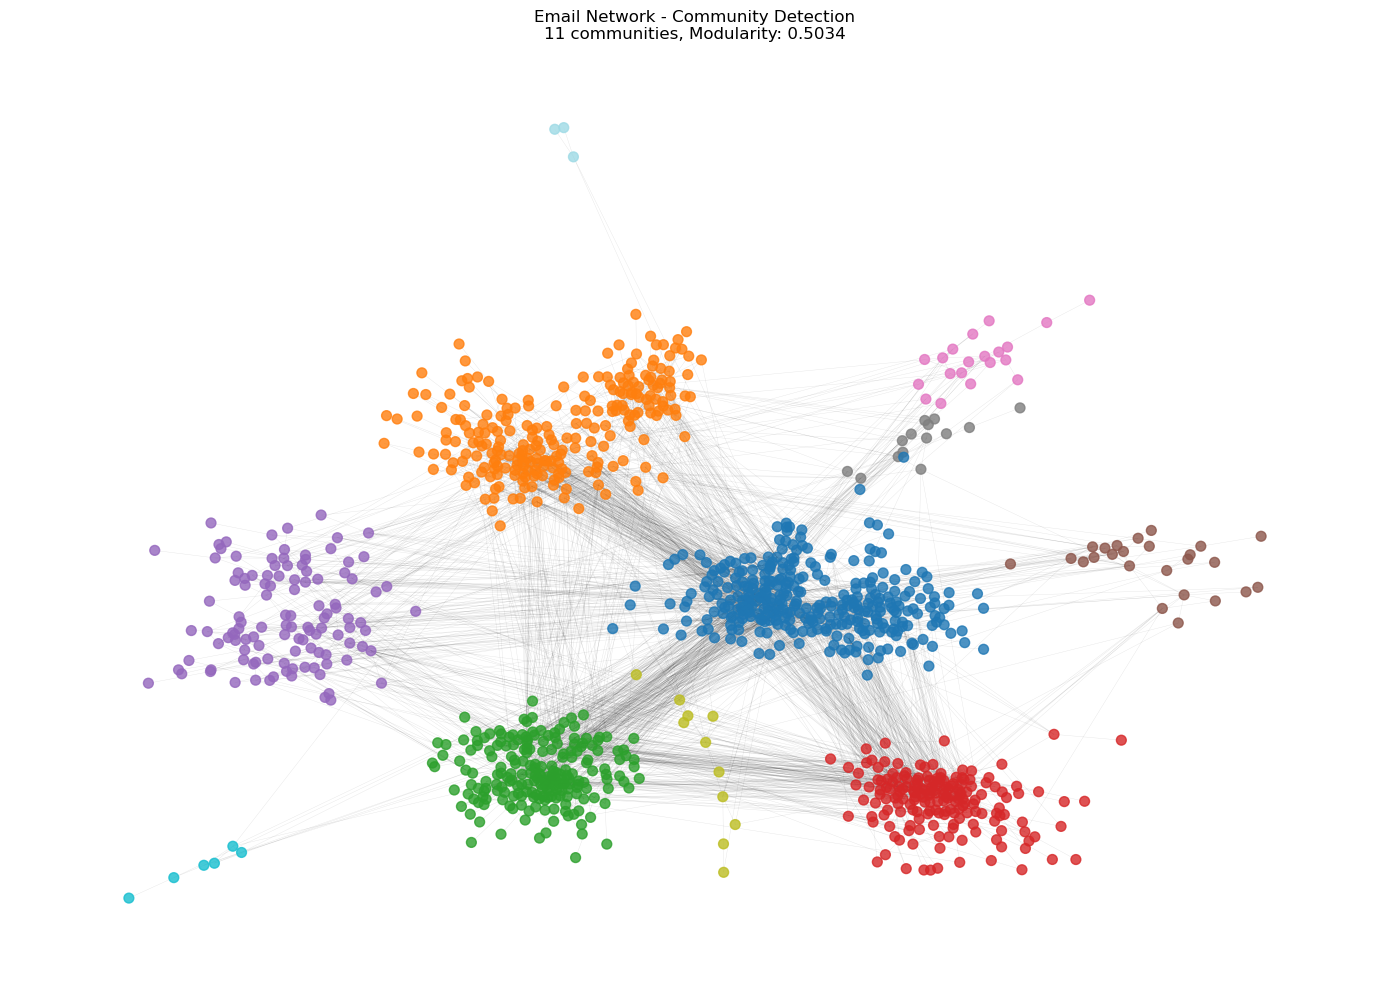

In [3]:
communities = nx.community.greedy_modularity_communities(G)
communities = list(communities)

partition_a = {}
for community_id, community in enumerate(communities):
    for node in community:
        partition_a[node] = community_id

modularity = nx.community.modularity(G, communities)
N_communities = len(communities)


print("Community sizes:")
cmap = plt.colormaps['tab20']
norm = plt.Normalize(vmin=0, vmax=N_communities-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for i, community in enumerate(communities):
    color = sm.to_rgba(i)
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))
    print(f"  Community {i}: {len(community)} nodes - Color: {hex_color}")

plt.figure(figsize=(14, 10))

# Visualization Graph
G_weighted = copy.deepcopy(G)
for u, v in G_weighted.edges():
    if partition_a[u] == partition_a[v]:
        G_weighted[u][v]['weight'] = 10.0
    else:
        G_weighted[u][v]['weight'] = 0.1

# Use spring layout with weights - same community nodes attract more strongly
pos = nx.spring_layout(G_weighted, weight='weight', k=0.5, iterations=100, seed=55)


node_colors = [partition_a[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                       node_size=50, cmap='tab20', alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3)

plt.title(f"Email Network - Community Detection\n{N_communities} communities, Modularity: {modularity:.4f}")
plt.axis('off')
plt.tight_layout()
plt.savefig('problem_2_a.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

Graph-tool detected 21 communities

Community sizes (sorted by size):
  Community 0: 156 nodes - Color: #000000
  Community 1: 111 nodes - Color: #70007f
  Community 2: 110 nodes - Color: #870098
  Community 3: 84 nodes - Color: #0200a9
  Community 4: 80 nodes - Color: #0000dd
  Community 5: 75 nodes - Color: #0077dd
  Community 6: 64 nodes - Color: #0097dd
  Community 7: 59 nodes - Color: #00a9ab
  Community 8: 53 nodes - Color: #00aa87
  Community 9: 47 nodes - Color: #009900
  Community 10: 45 nodes - Color: #00bc00
  Community 11: 37 nodes - Color: #00dc00
  Community 12: 35 nodes - Color: #00ff00
  Community 13: 32 nodes - Color: #bbfe00
  Community 14: 31 nodes - Color: #eeec00
  Community 15: 25 nodes - Color: #ffc900
  Community 16: 25 nodes - Color: #ff9900
  Community 17: 24 nodes - Color: #fe0000
  Community 18: 22 nodes - Color: #dc0000
  Community 19: 10 nodes - Color: #cc0c0c
  Community 20: 8 nodes - Color: #cccccc


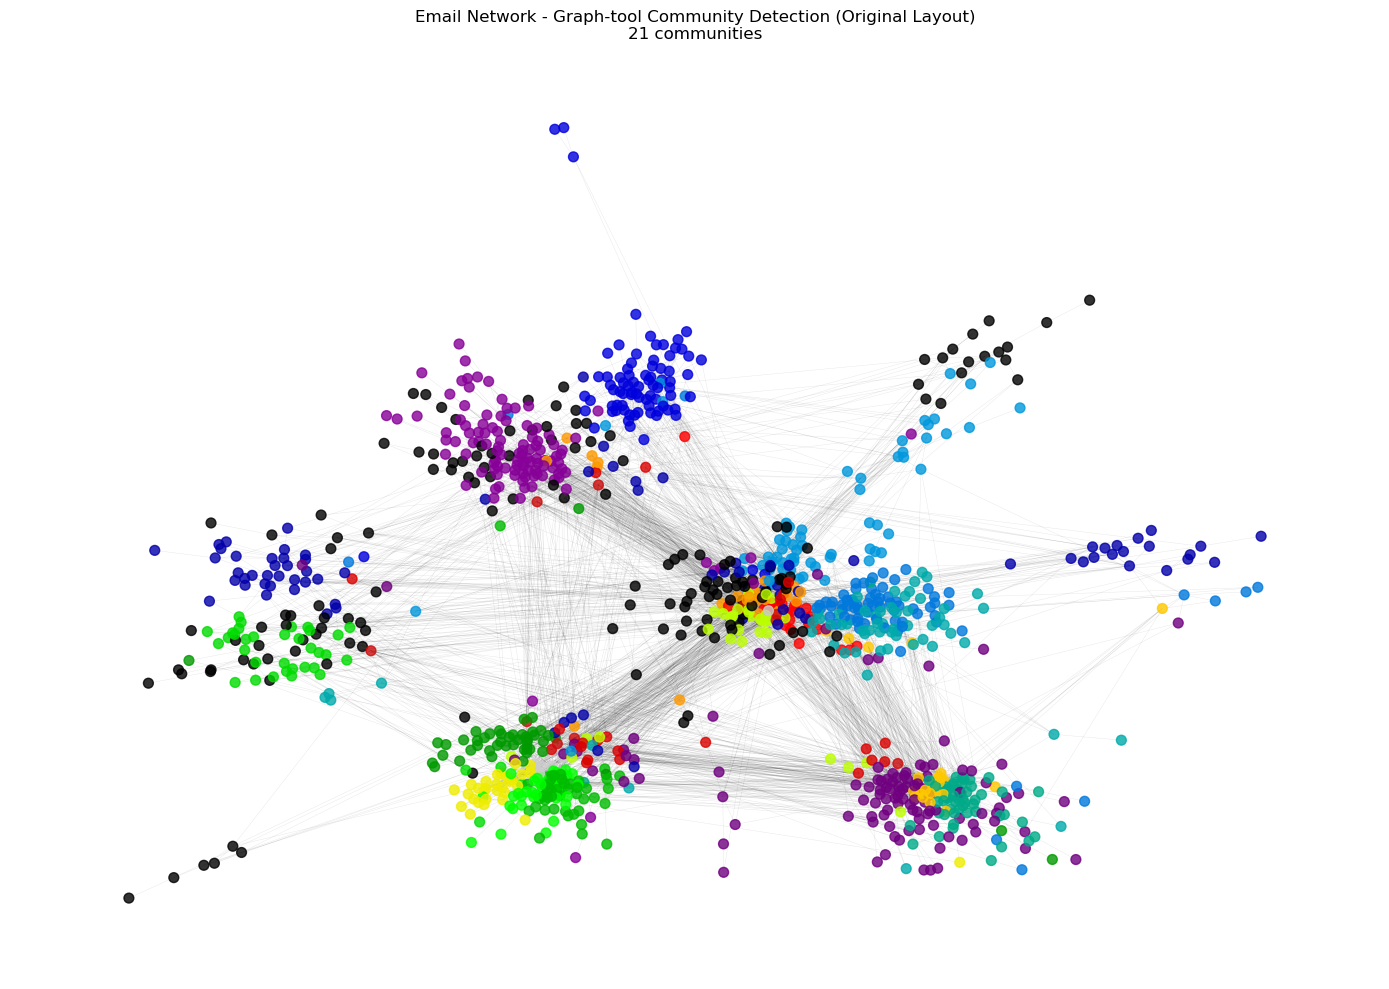

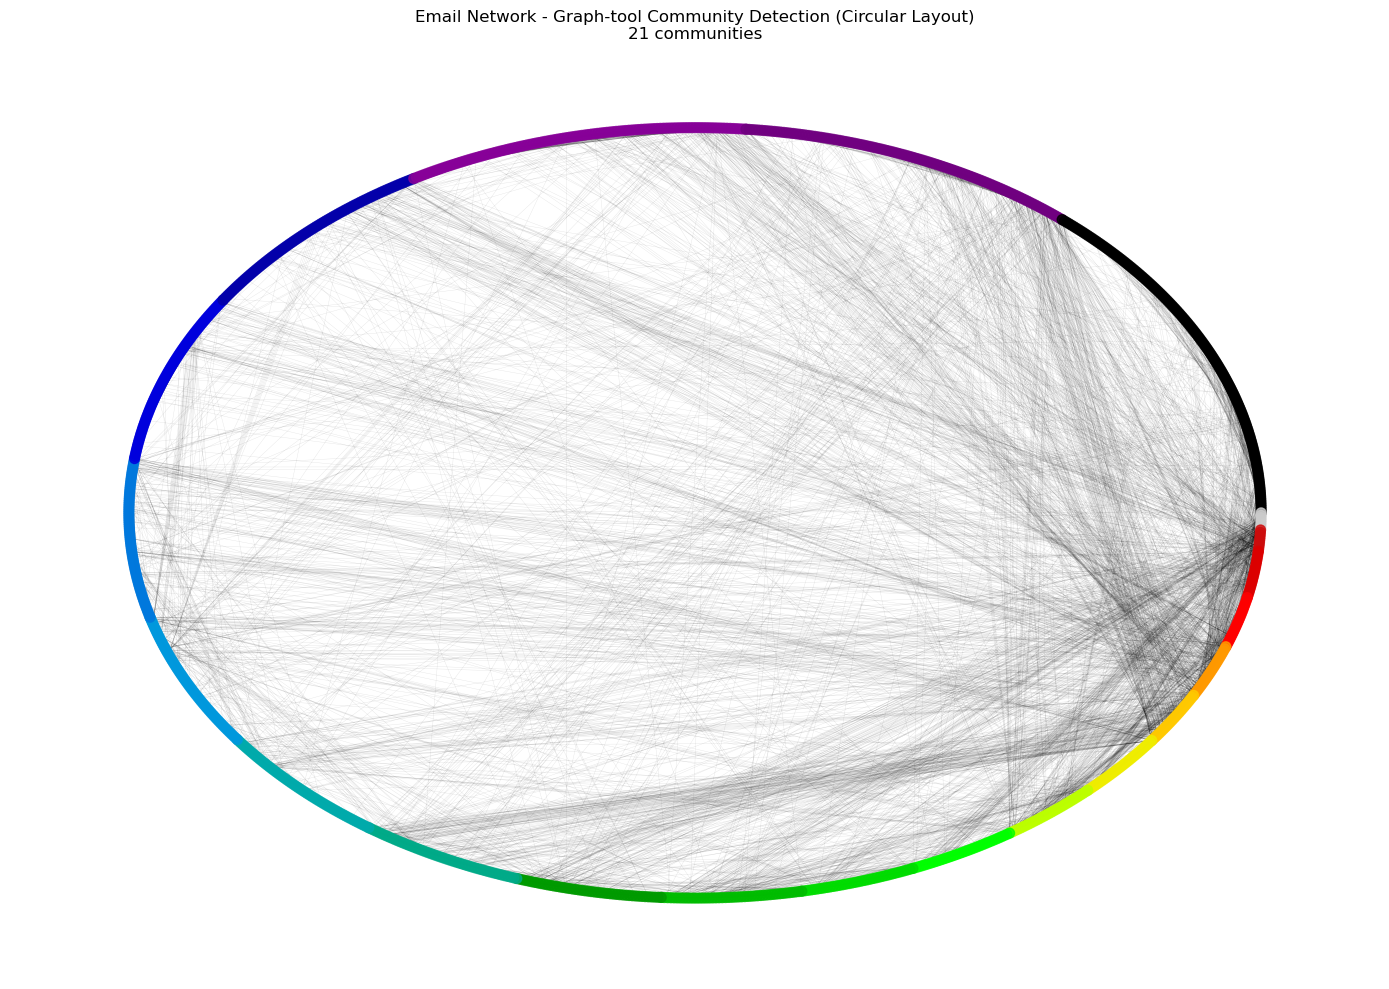

In [4]:
g = gt.Graph(directed=False)
node_to_vertex = {}
vertex_to_node = {}

for line in edge_lines:
    u, v = map(int, line.strip().split())
    
    if u not in node_to_vertex:
        vertex_u = g.add_vertex()
        node_to_vertex[u] = int(vertex_u)
        vertex_to_node[int(vertex_u)] = u
    if v not in node_to_vertex:
        vertex_v = g.add_vertex()
        node_to_vertex[v] = int(vertex_v)
        vertex_to_node[int(vertex_v)] = v
    
    g.add_edge(node_to_vertex[u], node_to_vertex[v])

state = gt.minimize_blockmodel_dl(g)

community_membership = state.get_blocks()

partition_b = {}
for v in g.vertices():
    node_id = vertex_to_node[int(v)]
    partition_b[node_id] = int(community_membership[v])

community_counts = Counter(partition_b.values())

sorted_communities = sorted(community_counts.keys(), key=lambda x: (-community_counts[x], x))
community_remap = {old_id: new_id for new_id, old_id in enumerate(sorted_communities)}

N_communities_gt = len(sorted_communities)
print(f"Graph-tool detected {N_communities_gt} communities")

cmap_gt = plt.colormaps['nipy_spectral']
norm_gt = plt.Normalize(vmin=0, vmax=N_communities_gt-1)
sm_gt = plt.cm.ScalarMappable(cmap=cmap_gt, norm=norm_gt)

print("\nCommunity sizes (sorted by size):")
for new_id, old_id in enumerate(sorted_communities):
    color = sm_gt.to_rgba(new_id)
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))
    print(f"  Community {new_id}: {community_counts[old_id]} nodes - Color: {hex_color}")

partition_b = {node: community_remap[comm] for node, comm in partition_b.items()}

# Plot 1: Using original layout (from partition_a)
plt.figure(figsize=(14, 10))

node_colors_gt = [partition_b[node] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors_gt, 
                       node_size=50, cmap='nipy_spectral', alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3)

plt.title(f"Email Network - Graph-tool Community Detection (Original Layout)\n{N_communities_gt} communities")
plt.axis('off')
plt.tight_layout()
plt.savefig('problem_2_b_1.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot 2: Circular layout with communities proportional to their size
# Group nodes by community
community_nodes = {}
for node, comm in partition_b.items():
    if comm not in community_nodes:
        community_nodes[comm] = []
    community_nodes[comm].append(node)

# Create circular layout where arc length is proportional to community size
pos_gt = {}
radius = 10.0
total_nodes = G.number_of_nodes()

# Calculate starting angle for each community
current_angle = 0.0

for comm_id in range(N_communities_gt):
    nodes_in_comm = community_nodes[comm_id]
    n_nodes = len(nodes_in_comm)
    
    # Arc length proportional to number of nodes in this community
    arc_length = (n_nodes / total_nodes) * 2 * np.pi
    
    # Position each node along the arc for this community
    for i, node in enumerate(nodes_in_comm):
        # Spread nodes evenly across the arc
        if n_nodes == 1:
            angle = current_angle + arc_length / 2
        else:
            angle = current_angle + (i / (n_nodes - 1)) * arc_length
        
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        pos_gt[node] = np.array([x, y])
    
    # Move to next community's starting position
    current_angle += arc_length

plt.figure(figsize=(14, 10))

nx.draw_networkx_nodes(G, pos_gt, node_color=node_colors_gt, 
                       node_size=50, cmap='nipy_spectral', alpha=0.8)
nx.draw_networkx_edges(G, pos_gt, alpha=0.1, width=0.3)

plt.title(f"Email Network - Graph-tool Community Detection (Circular Layout)\n{N_communities_gt} communities")
plt.axis('off')
plt.tight_layout()
plt.savefig('problem_2_b_2.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
original_degree_sequence = [d for n, d in G.degree()]
G_random = nx.configuration_model(original_degree_sequence)
G_random = nx.Graph(G_random)
G_random.remove_edges_from(nx.selfloop_edges(G_random))

print("Randomized Network Properties:")
print(f"Number of nodes: {G_random.number_of_nodes()}")
print(f"Number of edges: {G_random.number_of_edges()}")
print(f"Is connected: {nx.is_connected(G_random)}")

with open('randomized_network.edgelist.txt', 'w') as f:
    for u, v in G_random.edges():
        f.write(f"{u} {v}\n")

Randomized Network Properties:
Number of nodes: 1133
Number of edges: 5348
Is connected: False


In [6]:
# Community detection from a
print("Community detection from a\n")

communities_random_a = nx.community.greedy_modularity_communities(G_random)
communities_random_a = list(communities_random_a)

partition_c_1 = {}
for community_id, community in enumerate(communities_random_a):
    for node in community:
        partition_c_1[node] = community_id

modularity_random_a = nx.community.modularity(G_random, communities_random_a)
N_communities_random_a = len(communities_random_a)

print(f"Detected {N_communities_random_a} communities")
print(f"Modularity: {modularity_random_a:.4f}")
print("\n")

Community detection from a

Detected 10 communities
Modularity: 0.2833


Detected 10 communities
Modularity: 0.2833




In [7]:
# Community detection from b
print("Community detection from b\n")

g_random = gt.Graph(directed=False)
node_to_vertex_random = {}
vertex_to_node_random = {}

with open('randomized_network.edgelist.txt', 'r') as f:
    for line in f:
        u, v = map(int, line.strip().split())
        
        if u not in node_to_vertex_random:
            vertex_u = g_random.add_vertex()
            node_to_vertex_random[u] = int(vertex_u)
            vertex_to_node_random[int(vertex_u)] = u
        if v not in node_to_vertex_random:
            vertex_v = g_random.add_vertex()
            node_to_vertex_random[v] = int(vertex_v)
            vertex_to_node_random[int(vertex_v)] = v
        
        g_random.add_edge(node_to_vertex_random[u], node_to_vertex_random[v])

state_random = gt.minimize_blockmodel_dl(g_random)
community_membership_random = state_random.get_blocks()

partition_d = {}
for v in g_random.vertices():
    node_id = vertex_to_node_random[int(v)]
    partition_d[node_id] = int(community_membership_random[v])

N_communities_gt_random = len(set(partition_d.values()))

print(f"Detected {N_communities_gt_random} communities")
print("\n")

Community detection from b

Detected 1 communities


Detected 1 communities




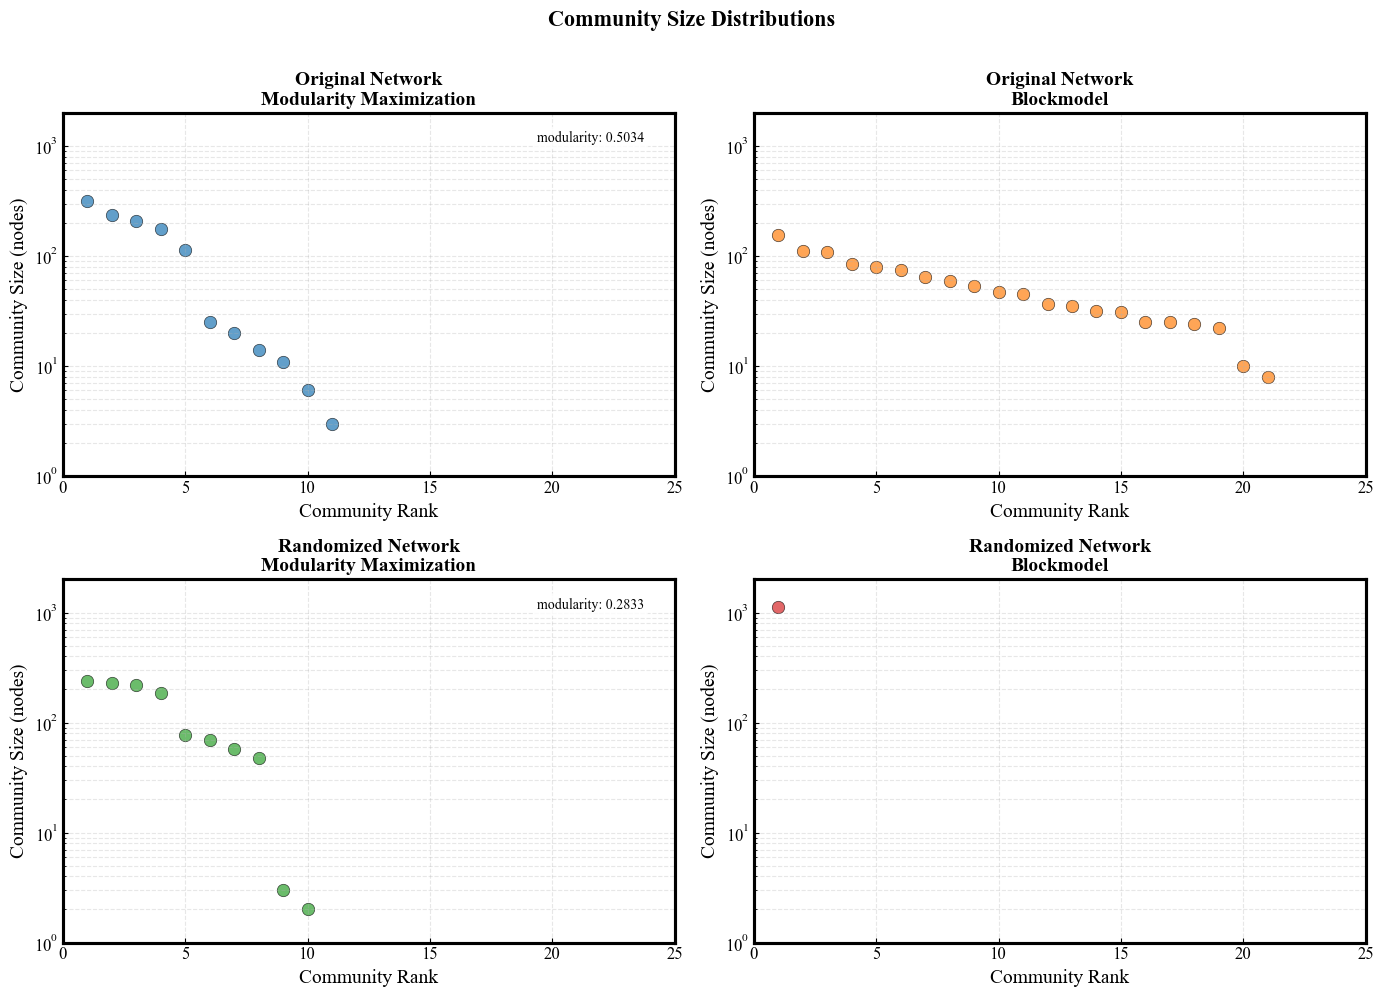

In [ ]:
y_final = 2000

# Community size distributions for all four partitions
# Set formatting to match publication style
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get community sizes for each partition
def get_community_sizes(partition):
    """Returns sorted list of community sizes from a partition dictionary"""
    community_counts = Counter(partition.values())
    return sorted(community_counts.values(), reverse=True)

sizes_a = get_community_sizes(partition_a)
sizes_b = get_community_sizes(partition_b)
sizes_c = get_community_sizes(partition_c_1)
sizes_d = get_community_sizes(partition_d)

# Plot 1: Original Network - Greedy Modularity (partition_a)
ax1 = axes[0, 0]
ax1.scatter(range(1, len(sizes_a) + 1), sizes_a, color='#1f77b4', s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Community Rank')
ax1.set_ylabel('Community Size (nodes)')
ax1.set_title('Original Network\nModularity Maximization', fontweight='bold')
ax1.set_yscale('log')
ax1.set_xlim(0, 25)
ax1.set_ylim(1, y_final)
ax1.grid(True, alpha=0.3, which='both', linestyle='--')
for spine in ax1.spines.values():
    spine.set_linewidth(2.25)
ax1.tick_params(direction='in', which='both')
ax1.text(0.95, 0.95, f'modularity: {modularity:.4f}', transform=ax1.transAxes, 
         ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, linewidth=0))

# Plot 2: Original Network - Graph-tool (partition_b)
ax2 = axes[0, 1]
ax2.scatter(range(1, len(sizes_b) + 1), sizes_b, color='#ff7f0e', s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Community Rank')
ax2.set_ylabel('Community Size (nodes)')
ax2.set_title('Original Network\nBlockmodel', fontweight='bold')
ax2.set_yscale('log')
ax2.set_xlim(0, 25)
ax2.set_ylim(1, y_final)
ax2.grid(True, alpha=0.3, which='both', linestyle='--')
for spine in ax2.spines.values():
    spine.set_linewidth(2.25)
ax2.tick_params(direction='in', which='both')

# Plot 3: Randomized Network - Greedy Modularity (partition_c_1)
ax3 = axes[1, 0]
ax3.scatter(range(1, len(sizes_c) + 1), sizes_c, color='#2ca02c', s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Community Rank')
ax3.set_ylabel('Community Size (nodes)')
ax3.set_title('Randomized Network\nModularity Maximization', fontweight='bold')
ax3.set_yscale('log')
ax3.set_xlim(0, 25)
ax3.set_ylim(1, y_final)
ax3.grid(True, alpha=0.3, which='both', linestyle='--')
for spine in ax3.spines.values():
    spine.set_linewidth(2.25)
ax3.tick_params(direction='in', which='both')
ax3.text(0.95, 0.95, f'modularity: {modularity_random_a:.4f}', transform=ax3.transAxes, 
         ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, linewidth=0))

# Plot 4: Randomized Network - Graph-tool (partition_d)
ax4 = axes[1, 1]
ax4.scatter(range(1, len(sizes_d) + 1), sizes_d, color='#d62728', s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Community Rank')
ax4.set_ylabel('Community Size (nodes)')
ax4.set_title('Randomized Network\nBlockmodel', fontweight='bold')
ax4.set_yscale('log')
ax4.set_xlim(0, 25)
ax4.set_ylim(1, y_final)
ax4.grid(True, alpha=0.3, which='both', linestyle='--')
for spine in ax4.spines.values():
    spine.set_linewidth(2.25)
ax4.tick_params(direction='in', which='both')

# Add overall title
fig.suptitle('Community Size Distributions', fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('problem_2_d.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


## Question 3

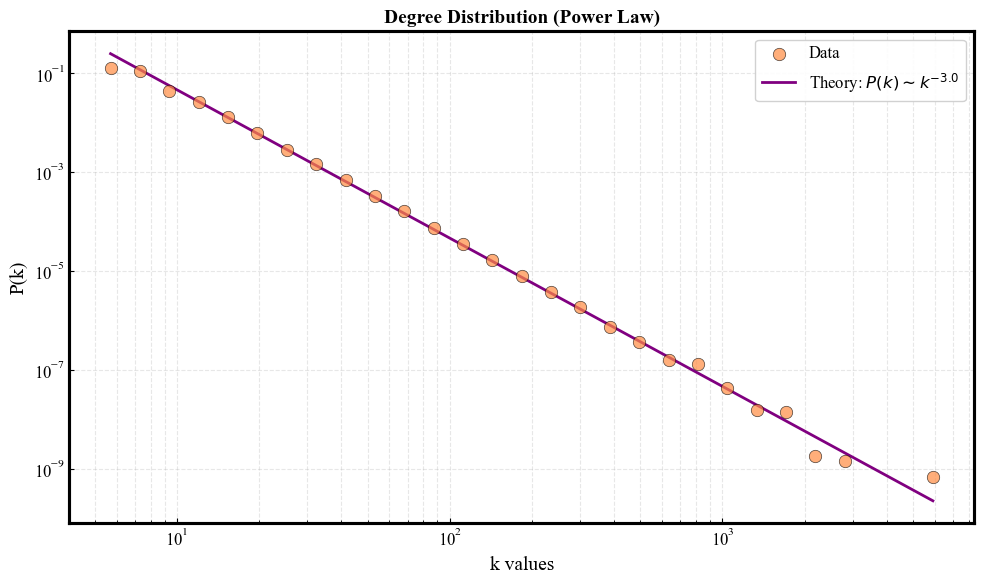

In [88]:
def ktransform(u, gamma, kmed):
    return np.floor( (gamma-2)/(gamma-1) * kmed * (1 - u)**(-1/(gamma-1)) )

gamma = 3.0
kmed = 10
N_gens = 1000000

random_numbers = np.random.rand(N_gens)
degree_dist = [ktransform(k, gamma, kmed) for k in random_numbers]

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(10, 6))

bins = np.logspace(np.log10(min(degree_dist)), np.log10(max(degree_dist)), 30)
counts, bin_edges = np.histogram(degree_dist, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

prob_density = counts / (N_gens * bin_widths)

mask = prob_density > 0
bin_centers_filtered = bin_centers[mask]
prob_density_filtered = prob_density[mask]

log_k = np.log10(bin_centers_filtered)
log_prob = np.log10(prob_density_filtered)

slope = -gamma

intercept = np.mean(log_prob - slope * log_k)

k_fit = np.logspace(np.log10(bin_centers_filtered.min()), np.log10(bin_centers_filtered.max()), 100)
prob_fit = 10**(slope * np.log10(k_fit) + intercept)

plt.scatter(bin_centers, prob_density, color='#FF8C42', s=80, alpha=0.7, edgecolors='black', linewidth=0.5, label='Data', zorder=3)
plt.plot(k_fit, prob_fit, color='purple', linewidth=2, label=rf'Theory: $P(k) \sim k^{{-{gamma:.1f}}}$', zorder=2)
plt.xlabel('k values')
plt.ylabel('P(k)')
plt.title('Degree Distribution (Power Law)', fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(True, alpha=0.3, which='both', linestyle='--')

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2.25)
ax.tick_params(direction='in', which='both')

plt.tight_layout()
plt.savefig('problem_3_b_1.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [80]:
def Stransform(u, beta, Smin):
    return np.floor( Smin * (1 - u)**(-1/(beta-1)) )

kmin = min(degree_dist)
kmax = max(degree_dist)

beta = 2
Smin = kmin+1

S_list = []

running_S_creation = True

while running_S_creation:
    if sum(S_list) < N_gens:
        S_list.append(Stransform(np.random.rand(), beta, Smin))
    elif sum(S_list) > N_gens:
        S_list.pop(np.random.randint(0, len(S_list)))
    else:
        if max(S_list) > kmax:
            running_S_creation = False
        else:
            S_list.pop(np.random.randint(0, len(S_list)))


In [81]:
available_nodes = list(enumerate(degree_dist))
communities = [[] for _ in range(len(S_list))]

rejections = 0
max_reject = 10000000

while available_nodes and rejections < max_reject:
    node_id, degree = available_nodes.pop(0)
    random_community_index = np.random.randint(0, len(S_list))
    
    if degree < S_list[random_community_index]:
        
        while len(communities[random_community_index]) >= S_list[random_community_index]:
            kick_index = np.random.randint(0, len(communities[random_community_index]) )
            kicked_node = communities[random_community_index].pop(kick_index)
            available_nodes.append(kicked_node)

        communities[random_community_index].append((node_id,degree))
        
    else:
        rejections += 1
        available_nodes.append((node_id, degree))
        

print(rejections)

10000000


In [82]:
new_communities = copy.deepcopy(communities)
print(len(available_nodes))

328835


In [83]:
mu = 0.7

for i in range(len(new_communities)):
    for j in range(len(new_communities[i])):
        node_id, degree = new_communities[i][j]

        kin = 0
        kout = 0
        for trial in range(int(degree)):
            if np.random.rand() < mu:
                kout += 1
            else:
                kin += 1
        new_communities[i][j] = (node_id, degree, kin, kout)

In [84]:
print(new_communities[0][2])
print(new_communities[0][3])
print(len(new_communities))

(769757, np.float64(9.0), 1, 8)
(385962, np.float64(7.0), 1, 6)
16905


## Question 4

In [2]:
pip install git+https://github.com/giuliano-porciuncula/netscidata2fall2025pipassignment.git

  Cloning https://github.com/giuliano-porciuncula/netscidata2fall2025pipassignment.git to /private/var/folders/1n/rqr82kgs60s4205zxs_lb3t00000gn/T/pip-req-build-hqq54x6l
  Running command git clone --filter=blob:none --quiet https://github.com/giuliano-porciuncula/netscidata2fall2025pipassignment.git /private/var/folders/1n/rqr82kgs60s4205zxs_lb3t00000gn/T/pip-req-build-hqq54x6l
  Resolved https://github.com/giuliano-porciuncula/netscidata2fall2025pipassignment.git to commit c14d9e17cb6046d21ac85a536bee1c01996c5548
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for netscidata2fall2025pipassignment: filename=netscidata2fall2025pipassignment-0.1.0-py3-none-any.whl size=8124 sha256=423f086c07292593bb6d2fd09488bf74b9f152f3c3e2d119640a9b98177d53f0
  Stored in directory: /private/var/folders/1n/rqr82kgs60s4205zxs_lb3t00000gn/T/pip-ephem-wheel-cache-iwwx0_t4/wheels/2f/e0/87/cd4329f3016da2bf

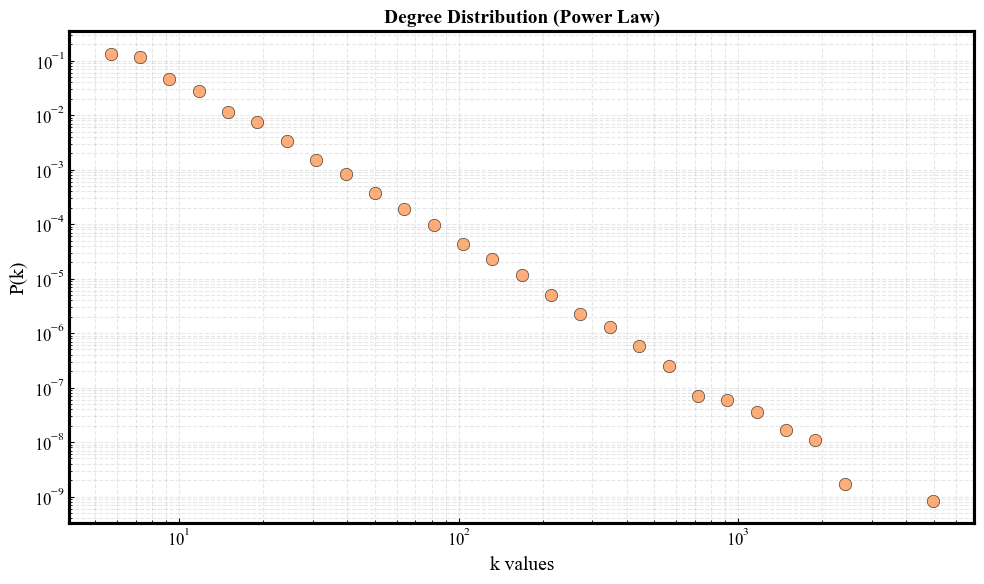

In [3]:
from netscidata2fall2025pipassignment import plot_degree_dist_log_log, generate_powerlaw_degree_list

degree_dist = generate_powerlaw_degree_list(gamma=3.0, kmed=10, n_nodes=1000000)

plot_degree_dist_log_log(degree_dist)

## Works perfectly :D